# Setup

In [1]:
## Install required packages
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
#!pip install transformers==4.21.2
#!pip install sentencepiece==0.1.96
#!pip install datasets
#!pip install nltk
#!pip install sentence_transformers
#!pip install gensim
#!pip install torchtext


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.manifold import trustworthiness
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, classification_report, f1_score, silhouette_score
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import torch
from transformers import XLMRobertaForSequenceClassification, BertForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, DataCollatorForLanguageModeling, RobertaForSequenceClassification, TrainingArguments, Trainer, BertModel
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from datasets import Dataset, DatasetDict
from utils import functions
import random
import nltk
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
import re
from nltk.corpus import stopwords
from gensim.utils import tokenize as tk
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, strip_tags, strip_punctuation, strip_numeric, strip_multiple_whitespaces
from gensim.models import Doc2Vec
from collections import namedtuple
from gensim.models.phrases import Phrases, Phraser
from gensim.models.doc2vec import TaggedDocument
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
from sklearn.decomposition import PCA, TruncatedSVD
from pynndescent import NNDescent
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set


In [3]:
import math

In [4]:
torch.cuda.empty_cache() 
device = torch.device('cuda')
torch.cuda.get_device_name(device=None)


'NVIDIA GeForce RTX 3090'

In [5]:
## Pseudo-randomness for reproducibility
seed_val = 1234
torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)

# Application: Using CMP-annotated data as data for classification and supervised dimensionality reduction

### Data preparation

In [6]:
manifesto = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes.csv"), encoding="utf-8")

In [7]:
manifesto.head()

,text,election,code,pos,party_code,country_code,party,country,name,name_english
0,La France est plus riche que jamais.,2012,503,3,31021_201206,31,31021,France,Front de Gauche,Left Front
1,Mais jamais non plus cette richesse n'a été au...,2012,503,4,31021_201206,31,31021,France,Front de Gauche,Left Front
2,Les réformes libérales qui se sont encore accé...,2012,503,5,31021_201206,31,31021,France,Front de Gauche,Left Front
3,"La pauvreté et la précarité se sont étendues, ...",2012,503,6,31021_201206,31,31021,France,Front de Gauche,Left Front
4,L'égoïsme social des possédants viole l'intérê...,2012,503,7,31021_201206,31,31021,France,Front de Gauche,Left Front


In [8]:
set(manifesto.code)

{'000',
 '101',
 '102',
 '103',
 '103.1',
 '103.2',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '201',
 '201.1',
 '201.2',
 '202',
 '202.1',
 '202.2',
 '202.3',
 '202.4',
 '203',
 '204',
 '301',
 '302',
 '303',
 '304',
 '305',
 '305.1',
 '305.2',
 '305.3',
 '305.5',
 '305.6',
 '401',
 '402',
 '403',
 '404',
 '405',
 '406',
 '407',
 '408',
 '409',
 '410',
 '411',
 '412',
 '413',
 '414',
 '415',
 '416',
 '416.1',
 '416.2',
 '501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '507',
 '601',
 '601.1',
 '601.2',
 '602',
 '602.1',
 '602.2',
 '603',
 '604',
 '605',
 '605.1',
 '605.2',
 '606',
 '606.1',
 '606.2',
 '607',
 '607.1',
 '607.2',
 '607.3',
 '608',
 '608.1',
 '608.2',
 '701',
 '702',
 '703',
 '703.1',
 '703.2',
 '704',
 '705',
 '706',
 'H'}

In [9]:
manifesto = manifesto[(manifesto.code.notna()) & ~(manifesto.code.isin(['000','H']))].reset_index(drop=True)

In [10]:
set(manifesto.code)

{'101',
 '102',
 '103',
 '103.1',
 '103.2',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '201',
 '201.1',
 '201.2',
 '202',
 '202.1',
 '202.2',
 '202.3',
 '202.4',
 '203',
 '204',
 '301',
 '302',
 '303',
 '304',
 '305',
 '305.1',
 '305.2',
 '305.3',
 '305.5',
 '305.6',
 '401',
 '402',
 '403',
 '404',
 '405',
 '406',
 '407',
 '408',
 '409',
 '410',
 '411',
 '412',
 '413',
 '414',
 '415',
 '416',
 '416.1',
 '416.2',
 '501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '507',
 '601',
 '601.1',
 '601.2',
 '602',
 '602.1',
 '602.2',
 '603',
 '604',
 '605',
 '605.1',
 '605.2',
 '606',
 '606.1',
 '606.2',
 '607',
 '607.1',
 '607.2',
 '607.3',
 '608',
 '608.1',
 '608.2',
 '701',
 '702',
 '703',
 '703.1',
 '703.2',
 '704',
 '705',
 '706'}

In [11]:
def extract_code(code):
    if len(code.split('.')) > 1:
        return(int(code.split('.')[0]))
    else:
        return int(code)
manifesto['code_extract'] = manifesto['code'].apply(extract_code)

In [12]:
len(set(manifesto.code_extract))

56

In [13]:
def sentiment_code(code):
    if code in [104,201,203,305,401,402,407,414,505,601,603,605,606,410]:                                       ## social - liberal                                                  
        return('right')
    elif code in [103,105,106,107,202,403,404,406,412,413,504,506,701,501,416]:                                             ## social - liberal                                 
        return('left')
    else:
        return('neutral')

    

In [14]:
manifesto.loc[:,'sentiment'] = manifesto.loc[:,'code_extract'].apply(sentiment_code)

In [15]:
manifesto.groupby('sentiment').count()

,text,election,code,pos,party_code,country_code,party,country,name,name_english,code_extract
sentiment,,,,,,,,,,,
left,116160,116160,116160,116160,116160,116160,116160,116160,116160,116160,116160
neutral,117309,117309,117309,117309,117309,117309,117309,117309,117309,117309,117309
right,54695,54695,54695,54695,54695,54695,54695,54695,54695,54695,54695


In [16]:
manifesto.groupby(['country','election']).count()

text   code    pos  party_code  country_code  party  \
country        election                                                         
France         2012       4809   4809   4809        4809          4809   4809   
               2017       3460   3460   3460        3460          3460   3460   
Germany        1998       6046   6046   6046        6046          6046   6046   
               2002       7339   7339   7339        7339          7339   7339   
               2005       5479   5479   5479        5479          5479   5479   
               2009      11624  11624  11624       11624         11624  11624   
               2013      17629  17629  17629       17629         17629  17629   
               2017      14779  14779  14779       14779         14779  14779   
               2021      18407  18407  18407       18407         18407  18407   
Italy          2001       3829   3829   3829        3829          3829   3829   
               2008        718    718    718         718           718    718   
               2013       4301   4301   4301        4301          4301   4301   
               2018      10881  10881  10881       10881         10881  10881   
Spain          1996       4378   4378   4378        4378          4378   4378   
               2000      16794  16794  16794       16794         16794  16794   
               2004       6725   6725   6725        6725          6725   6725   
               2008      17803  17803  17803       17803         17803  17803   
               2011      14910  14910  14910       14910         14910  14910   
               2015      23545  23545  23545       23545         23545  23545   
               2016      18511  18511  18511       18511         18511  18511   
               2019      29881  29881  29881       29881         29881  29881   
United Kingdom 1997       1451   1451   1451        1451          1451   1451   
               2001       2195   2195   2195        2195          2195   2195   
               2015      11033  11033  11033       11033         11033  11033   
               2017       6988   6988   6988        6988          6988   6988   
               2019       9269   9269   9269        9269          9269   9269   
United States  1992        383    383    383         383           383    383   
               2004       2644   2644   2644        2644          2644   2644   
               2008       1002   1002   1002        1002          1002   1002   
               2012       2893   2893   2893        2893          2893   2893   
               2016       3679   3679   3679        3679          3679   3679   
               2020       4779   4779   4779        4779          4779   4779   

                          name  name_english  code_extract  sentiment  
country        election                                                
France         2012       4809          4809          4809       4809  
               2017       3460          3460          3460       3460  
Germany        1998       6046          6046          6046       6046  
               2002       7339          7339          7339       7339  
               2005       5479          5479          5479       5479  
               2009      11624         11624         11624      11624  
               2013      17629         17629         17629      17629  
               2017      14779         14779         14779      14779  
               2021      18407         18407         18407      18407  
Italy          2001       3829          3829          3829       3829  
               2008        718           718           718        718  
               2013       4301          4301          4301       4301  
               2018      10881         10881         10881      10881  
Spain          1996       4378          4378          4378       4378  
               2000      16794         16794         16794      16794  
               2004       6725          6725   

In [17]:
texts = manifesto['text'].tolist()

In [18]:
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 20.442796463125166
Std length (word) is: 12.823326822581686
Min length (word) is: 1
Max length (word) is: 160


<AxesSubplot: >

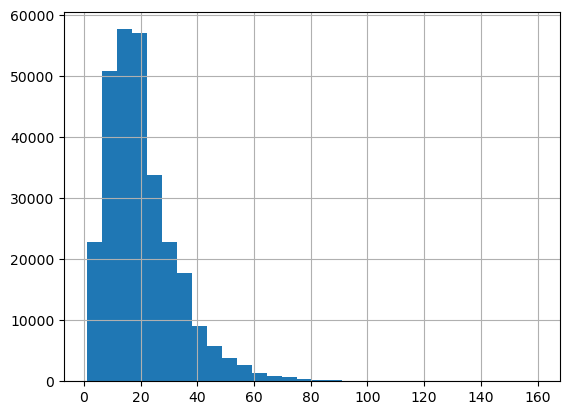

In [19]:
pd.Series(seq_len).hist(bins = 30)

In [20]:
manifesto['country_party_election_sentiment'] = manifesto.country.str.cat(others=[manifesto.name, manifesto.election.astype(str), 
manifesto.sentiment], sep='_')

In [21]:
def group_texts(dataset, labels_col, text_col, group_factor=5):
    results = []
    labels = dataset[labels_col].tolist()
    for label in set(labels):
        ls_texts = []
        current_label = dataset[dataset[labels_col] == label]
        print(f'Length of {label} is: {len(current_label)}')
        texts = current_label[text_col].tolist()
        total_length = len(texts)
        for i in range(0,total_length,group_factor):
            text_to_append = ' '.join(texts[i:i+group_factor])
            ls_texts.append(text_to_append)
        result = {
            'text': ls_texts,
            'labels': label
        }                  
        results.append(result)
    return(results)   

In [22]:
results = group_texts(manifesto, 'country_party_election_sentiment','text', group_factor = 3)

Length of Germany_Freie Demokratische Partei_1998_right is: 525
Length of Germany_Die Linke_2009_left is: 709
Length of Spain_Bloque Nacionalista Galego_2008_neutral is: 978
Length of Spain_Coalición Canaria - Nueva Canarias_2011_right is: 91
Length of United Kingdom_Liberal Democrats_1997_right is: 203
Length of Spain_Ciudadanos - Partido de la Ciudadania_2016_left is: 385
Length of United Kingdom_Labour Party_2015_neutral is: 258
Length of Spain_Partido Popular_2000_neutral is: 1369
Length of Germany_Christlich-Demokratische Union/Christlich-Soziale Union_2002_right is: 522
Length of Germany_Bündnis‘90/Die Grünen_2013_right is: 787
Length of Germany_Christlich-Demokratische Union/Christlich-Soziale Union_2009_left is: 507
Length of Germany_Bündnis‘90/Die Grünen_2002_right is: 280
Length of Spain_Coalición Canaria - Nueva Canarias_2016_right is: 115
Length of Spain_Partido Nacionalista Vasco/Euzko Alderdi Jeltzalea_2015_right is: 112
Length of Germany_Sozialdemokratische Partei Deutsc

In [23]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [24]:
df_cols = manifesto_regrouped['labels'].str.split('_', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)

In [25]:
manifesto_regrouped.columns = ['text', 'country_party_election_sentiment', 'country','party', 'election', 'sentiment']

In [26]:
manifesto_regrouped

,text,country_party_election_sentiment,country,party,election,sentiment
0,Deutschland braucht ein geistiges Klima des Au...,Germany_Freie Demokratische Partei_1998_right,Germany,Freie Demokratische Partei,1998,right
1,"Die F.D.P appelliert an alle Kräfte, an alle G...",Germany_Freie Demokratische Partei_1998_right,Germany,Freie Demokratische Partei,1998,right
2,1998 geht es um eine Richtungsentscheidung: Fä...,Germany_Freie Demokratische Partei_1998_right,Germany,Freie Demokratische Partei,1998,right
3,zu Sozialer Marktwirtschaft anstelle bürokrati...,Germany_Freie Demokratische Partei_1998_right,Germany,Freie Demokratische Partei,1998,right
4,Mit der Wende zur marktwirtschaftlichen Erneue...,Germany_Freie Demokratische Partei_1998_right,Germany,Freie Demokratische Partei,1998,right
...,...,...,...,...,...,...
96260,"La France, troisième exportateur d'armes dans ...",France_Europe Écologie Les Verts_2012_left,France,Europe Écologie Les Verts,2012,left
96261,Une politique internationale et de sécurité de...,France_Europe Écologie Les Verts_2012_left,France,Europe Écologie Les Verts,2012,left
96262,Cela passe également par la fermeture et le dé...,France_Europe Écologie Les Verts_2012_left,France,Europe Écologie Les Verts,2012,left
96263,"Nous fermerons la base d'Abou Dhabi, qui s'ins...",France_Europe Écologie Les Verts_2012_left,France,Europe Écologie Les Verts,2012,left


### Classification with xlm-roberta-base

In [76]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [77]:
manifesto_reduced = manifesto_regrouped[['sentiment','text']]

In [78]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')
manifesto_dataset = manifesto_dataset.rename_column('sentiment','labels')



Parameter 'function'=<function Dataset.class_encode_column.<locals>.cast_to_class_labels at 0x00000241BFDA2E50> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Casting to class labels:   0%|          | 0/97 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/10 [00:00<?, ?ba/s]

In [79]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='labels', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='labels', seed=seed_val)

In [80]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 60646
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 9627
    })
    eval: Dataset({
        features: ['labels', 'text'],
        num_rows: 25992
    })
})

In [68]:
def tokenize_function(dataset):
    return tokenizer(dataset['text'], truncation=True)


In [84]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, batched=True, remove_columns=['text'])

  0%|          | 0/61 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

In [85]:
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [86]:
num_classes = len(set(manifesto['sentiment']))
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [88]:
## Declare important variables
batch_size = 32
num_epochs = 3
total_steps = len(tokenized_datasets['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [89]:
training_args = TrainingArguments(
    output_dir="results/multilingual/manifesto_3cl",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

In [90]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [91]:
trainer.train()

***** Running training *****
  Num examples = 60646
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5688
  Number of trainable parameters = 278045955


  0%|          | 0/5688 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.8149, 'learning_rate': 1.8020393811533053e-05, 'epoch': 0.3}
{'loss': 0.6401, 'learning_rate': 1.6023206751054854e-05, 'epoch': 0.6}
{'loss': 0.5771, 'learning_rate': 1.4029535864978905e-05, 'epoch': 0.9}


***** Running Evaluation *****
  Num examples = 25992
  Batch size = 32


  0%|          | 0/813 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.7867809490147566, 0.8263039934800326, 0.728339164437127]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.850105021959137, 0.7669251134644478, 0.716106839336301]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8172181175714743, 0.7955080423695566, 0.7221712070196918]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.850105021959137, 0.7669251134644478, 0.716106839336301]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we 

{'eval_loss': 0.5298818945884705, 'eval_precision': [0.7867809490147566, 0.8263039934800326, 0.728339164437127], 'eval_recall': [0.850105021959137, 0.7669251134644478, 0.716106839336301], 'eval_f1': [0.8172181175714743, 0.7955080423695566, 0.7221712070196918], 'eval_accuracy': [0.850105021959137, 0.7669251134644478, 0.716106839336301], 'eval_runtime': 40.1528, 'eval_samples_per_second': 647.328, 'eval_steps_per_second': 20.248, 'epoch': 1.0}


Model weights saved in results/multilingual/manifesto_3cl\checkpoint-1896\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl\checkpoint-1896\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl\checkpoint-1896\special_tokens_map.json


{'loss': 0.5045, 'learning_rate': 1.2032348804500704e-05, 'epoch': 1.2}
{'loss': 0.4662, 'learning_rate': 1.0035161744022504e-05, 'epoch': 1.5}
{'loss': 0.4503, 'learning_rate': 8.037974683544305e-06, 'epoch': 1.8}


***** Running Evaluation *****
  Num examples = 25992
  Batch size = 32


  0%|          | 0/813 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.827167520394612, 0.8362120907812813, 0.706300072833212]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.832537712430781, 0.7873487140695915, 0.7849048968029138]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8298439284354778, 0.8110450959384435, 0.7435307648073604]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.832537712430781, 0.7873487140695915, 0.7849048968029138]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we

{'eval_loss': 0.50733482837677, 'eval_precision': [0.827167520394612, 0.8362120907812813, 0.706300072833212], 'eval_recall': [0.832537712430781, 0.7873487140695915, 0.7849048968029138], 'eval_f1': [0.8298439284354778, 0.8110450959384435, 0.7435307648073604], 'eval_accuracy': [0.832537712430781, 0.7873487140695915, 0.7849048968029138], 'eval_runtime': 40.8958, 'eval_samples_per_second': 635.567, 'eval_steps_per_second': 19.88, 'epoch': 2.0}


Model weights saved in results/multilingual/manifesto_3cl\checkpoint-3792\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl\checkpoint-3792\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl\checkpoint-3792\special_tokens_map.json


{'loss': 0.4142, 'learning_rate': 6.0407876230661045e-06, 'epoch': 2.1}
{'loss': 0.3592, 'learning_rate': 4.043600562587905e-06, 'epoch': 2.4}
{'loss': 0.344, 'learning_rate': 2.0499296765119553e-06, 'epoch': 2.7}
{'loss': 0.339, 'learning_rate': 5.2742616033755277e-08, 'epoch': 3.0}


***** Running Evaluation *****
  Num examples = 25992
  Batch size = 32


  0%|          | 0/813 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.82586879762126, 0.8273740868896579, 0.761914629092416]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8485774298262364, 0.8139183055975794, 0.7440307567786322]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8370691278960255, 0.8205910390848427, 0.7528665028665029]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8485774298262364, 0.8139183055975794, 0.7440307567786322]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so w

{'eval_loss': 0.5222024917602539, 'eval_precision': [0.82586879762126, 0.8273740868896579, 0.761914629092416], 'eval_recall': [0.8485774298262364, 0.8139183055975794, 0.7440307567786322], 'eval_f1': [0.8370691278960255, 0.8205910390848427, 0.7528665028665029], 'eval_accuracy': [0.8485774298262364, 0.8139183055975794, 0.7440307567786322], 'eval_runtime': 41.171, 'eval_samples_per_second': 631.318, 'eval_steps_per_second': 19.747, 'epoch': 3.0}


Model weights saved in results/multilingual/manifesto_3cl\checkpoint-5688\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl\checkpoint-5688\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl\checkpoint-5688\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/manifesto_3cl\checkpoint-3792 (score: 0.50733482837677).


{'train_runtime': 1216.5212, 'train_samples_per_second': 149.556, 'train_steps_per_second': 4.676, 'train_loss': 0.4908372825627253, 'epoch': 3.0}


TrainOutput(global_step=5688, training_loss=0.4908372825627253, metrics={'train_runtime': 1216.5212, 'train_samples_per_second': 149.556, 'train_steps_per_second': 4.676, 'train_loss': 0.4908372825627253, 'epoch': 3.0})

In [92]:
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 9627
  Batch size = 32


  0%|          | 0/301 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8332042344435838, 0.8307610431080362, 0.7249498997995992]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8317010309278351, 0.7970385499106459, 0.7907103825136612]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8324519540822908, 0.8135504885993485, 0.7564035546262415]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8317010309278351, 0.7970385499106459, 0.7907103825136612]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect s

0.8008019991026268


In [93]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.83,0.83,0.83,0.83
1,0.81,0.83,0.80,0.80
2,0.76,0.72,0.79,0.79


In [94]:
round(res_table.mean(axis=0),2)

f1           0.80
precision    0.79
recall       0.81
accuracy     0.81
dtype: float64

### Scaling with Sentence Transformer and supervised dimensionality reduction (Germany)

#### Sentence Transformer to extract sentence embeddings

In [27]:
from utils.functions import party_deu, cmp_scale, encode_embeds

In [28]:
manifesto_deu = manifesto[manifesto['country'] == 'Germany'].reset_index(drop=True)
manifesto_deu_rgr = manifesto_regrouped[manifesto_regrouped['country'] == 'Germany'].reset_index(drop=True)

In [29]:
manifesto_deu['party_agg'] = manifesto_deu['name'].apply(party_deu)
manifesto_deu_rgr['party_agg'] = manifesto_deu_rgr['party'].apply(party_deu)

In [30]:
manifesto_deu = manifesto_deu[manifesto_deu.party_agg != 'NA'].reset_index(drop=True)
manifesto_deu_rgr = manifesto_deu_rgr[manifesto_deu_rgr.party_agg != 'NA'].reset_index(drop=True)

In [54]:
manifesto_deu_rgr.head()

,text,country_party_election_sentiment,country,party,election,sentiment,party_agg
0,Chancengleichheit statt Gleichmacherei. Weltof...,Germany_Freie Demokratische Partei_2005_neutral,Germany,Freie Demokratische Partei,2005,neutral,FDP
1,Die zentrale Staatsaufgabe ist nicht Gleichhei...,Germany_Freie Demokratische Partei_2005_neutral,Germany,Freie Demokratische Partei,2005,neutral,FDP
2,Arbeit ist mehr als Erwerbseinkommen. Arbeit b...,Germany_Freie Demokratische Partei_2005_neutral,Germany,Freie Demokratische Partei,2005,neutral,FDP
3,Das Streben nach Einzelfallgerechtigkeit hat l...,Germany_Freie Demokratische Partei_2005_neutral,Germany,Freie Demokratische Partei,2005,neutral,FDP
4,"Gerechtigkeit im Steuerrecht heißt, daß jeder ...",Germany_Freie Demokratische Partei_2005_neutral,Germany,Freie Demokratische Partei,2005,neutral,FDP


In [31]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu, group_vars=['party_agg','election'], sent_var='sentiment')

In [32]:
transformer_model = 'results/multilingual/manifesto_3cl/checkpoint-5688'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-5688 were not used when initializing XLMRobertaModel: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-5688 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to b

#### Scaling with Supervised UMAP

In [33]:
from utils.functions import scale_topic

In [34]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text',  ,'sentiment')

Now scaling texts in: ('AfD', '2013')
The shape of this document embeddings is: (26, 768)


ValueError: n_components=50 must be between 0 and min(n_samples, n_features)=26 with svd_solver='full'

In [76]:
umap_s_scaled = scale_topic(document_embed=document_embed, guide_labels=y, n_components=2, guidance_weight=0.8, random_state=seed_val)

UMAP(n_epochs=500, n_neighbors=500, random_state=1234, target_weight=0.8, verbose=True)
Wed Jul  5 20:30:25 2023 Construct fuzzy simplicial set
Wed Jul  5 20:30:25 2023 Finding Nearest Neighbors
Wed Jul  5 20:30:25 2023 Building RP forest with 13 trees
Wed Jul  5 20:30:25 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Wed Jul  5 20:30:52 2023 Finished Nearest Neighbor Search
Wed Jul  5 20:30:58 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Jul  5 20:32:35 2023 Finished embedding


In [77]:
emb_mean_dict = {}
for name, group in manifesto_deu_rgr.groupby(['party_agg','election']):
    idx = group.index
    embed = umap_s_scaled[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})


In [78]:
umap_s_embeds = np.stack(list(emb_mean_dict.values()))


In [81]:
np.corrcoef(relscale,umap_s_embeds[:,0])

array([[1.        , 0.23248279],
       [0.23248279, 1.        ]])

In [259]:
## Silhouette score
umap_s_silscore = silhouette_score(umap_s_scaled, y.flatten())
umap_s_silscore

0.8379493

In [260]:
## Trustworthiness
umap_s_trust = trustworthiness(document_embed, umap_s_scaled, n_neighbors=5)
umap_s_trust

0.9527295625935028

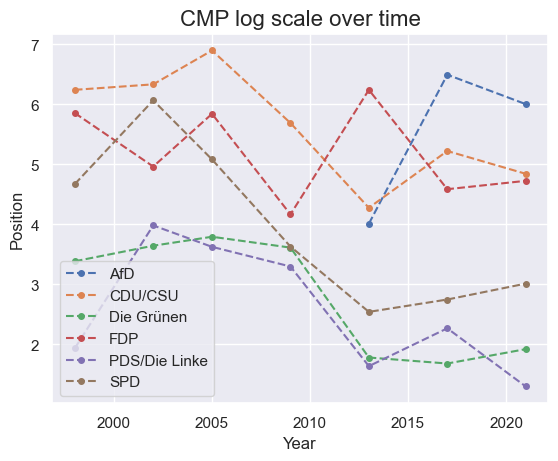

In [48]:
labels = ['_'.join([str(n) for n in name]) for name, group in manifesto_deu.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


df = pd.DataFrame({'dim1': umap_s_embeds[:,1], 'party': party, 'year': year, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) #,'dim2': score[:,1]
import matplotlib.pyplot as plt
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.year,group.dim1, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('CMP log scale over time', fontdict={'fontsize':16})
plt.plot()
plt.savefig('results/tabs and figs/figure5.png', dpi=300)

In [101]:
labels = ['_'.join([str(n) for n in name]) for name, group in manifesto_deu.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
election = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


df = pd.DataFrame({'party': party, 'election': election, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale})

In [103]:
labels

['AfD_2013',
 'AfD_2017',
 'AfD_2021',
 'CDU/CSU_1998',
 'CDU/CSU_2002',
 'CDU/CSU_2005',
 'CDU/CSU_2009',
 'CDU/CSU_2013',
 'CDU/CSU_2017',
 'CDU/CSU_2021',
 'Die Grünen_1998',
 'Die Grünen_2002',
 'Die Grünen_2005',
 'Die Grünen_2009',
 'Die Grünen_2013',
 'Die Grünen_2017',
 'Die Grünen_2021',
 'FDP_1998',
 'FDP_2002',
 'FDP_2005',
 'FDP_2009',
 'FDP_2013',
 'FDP_2017',
 'FDP_2021',
 'PDS/Die Linke_1998',
 'PDS/Die Linke_2002',
 'PDS/Die Linke_2005',
 'PDS/Die Linke_2009',
 'PDS/Die Linke_2013',
 'PDS/Die Linke_2017',
 'PDS/Die Linke_2021',
 'SPD_1998',
 'SPD_2002',
 'SPD_2005',
 'SPD_2009',
 'SPD_2013',
 'SPD_2017',
 'SPD_2021']

In [102]:
df.to_csv("results/arrays/df_cmp.csv", index=False)

In [158]:
## Save data
np.savetxt('results/arrays/umap_s_scaled.csv', umap_s_scaled)
np.savetxt('results/arrays/umap_s_embeds.csv', umap_s_embeds)


### Focus on one issue to show the differences 

In [83]:
transformer_model = 'results/multilingual/manifesto_3cl/checkpoint-5688'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-5688 were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-5688 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to b

In [184]:
manifesto_wf = manifesto[(manifesto['country'] == 'Germany') & (manifesto['code_extract'].isin([504,505]))].reset_index(drop=True)


In [185]:
manifesto_wf.loc[:,'party_agg'] = manifesto_wf['name'].apply(party_deu)
manifesto_wf = manifesto_wf[manifesto_wf.party_agg != 'NA'].reset_index(drop=True)

In [186]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_wf, group_vars=['party_agg','election'], sent_var='sentiment')

In [84]:
document_embed = encode_embeds(manifesto_wf, ['party_agg','election'], model)

In [85]:
document_embed.shape

(5307, 768)

In [86]:
enc = OrdinalEncoder()
guide_labels = enc.fit_transform(np.array(manifesto_wf['sentiment'].tolist()).reshape(-1,1))

In [88]:
umap_wf_scaled = scale_topic(document_embed=document_embed, n_components=2, random_state=seed_val, guide_labels=guide_labels)

UMAP(n_epochs=500, n_neighbors=250, random_state=1234, target_weight=0.8, verbose=True)
Sat Jun 17 12:24:12 2023 Construct fuzzy simplicial set
Sat Jun 17 12:24:12 2023 Finding Nearest Neighbors
Sat Jun 17 12:24:12 2023 Building RP forest with 9 trees
Sat Jun 17 12:24:12 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	Stopping threshold met -- exiting after 3 iterations
Sat Jun 17 12:24:15 2023 Finished Nearest Neighbor Search
Sat Jun 17 12:24:15 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Jun 17 12:24:32 2023 Finished embedding


In [89]:
emb_mean_dict = {}
for name, group in manifesto_wf.groupby(['party_agg','election']):
    idx = group.index
    embed = umap_wf_scaled[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})


In [187]:
umap_wf_embeds = np.stack(list(emb_mean_dict.values()))




NameError: name 'emb_mean_dict' is not defined

In [189]:
labels = ['_'.join([str(n) for n in name]) for name, group in manifesto_wf.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
election = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]
df = pd.DataFrame({'party': party, 'election': election, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) #,'dim2': score[:,1]


In [190]:
df.to_csv('results/arrays/wf_cmp.csv', index=False)

In [91]:
np.corrcoef(absscale, umap_wf_embeds[:,0])

array([[ 1.        , -0.97809474],
       [-0.97809474,  1.        ]])

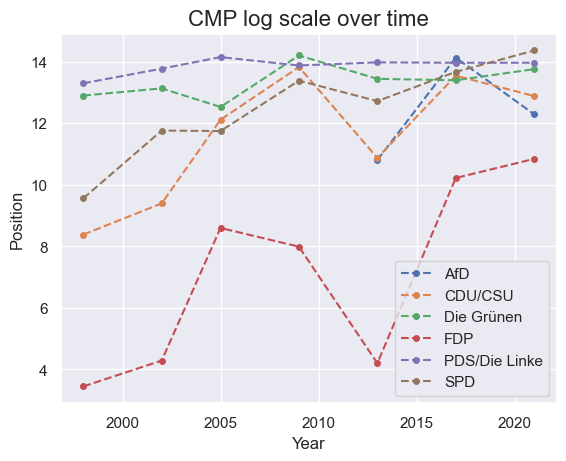

In [92]:
df = pd.DataFrame({'dim1': umap_wf_embeds[:,0],  'party': party, 'year': year, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) #,'dim2': score[:,1]
import matplotlib.pyplot as plt
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.year,group.dim1, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('CMP log scale over time', fontdict={'fontsize':16})
plt.plot()
plt.savefig('results/tabs and figs/figure5.png', dpi=300)

In [54]:
manifesto_wf.groupby(['party_agg','sentiment']).count()

text  election  code   pos  party_code  country_code  \
party_agg     sentiment                                                         
AfD           left        113       113   113   113         113           113   
              right         7         7     7     7           7             7   
CDU/CSU       left        543       543   543   543         543           543   
              right        68        68    68    68          68            68   
Die Grünen    left       1380      1380  1380  1380        1380          1380   
              right        21        21    21    21          21            21   
FDP           left        457       457   457   457         457           457   
              right       284       284   284   284         284           284   
PDS/Die Linke left       1467      1467  1467  1467        1467          1467   
              right         2         2     2     2           2             2   
SPD           left        916       916   916   916         916           916   
              right        49        49    49    49          49            49   

                         party  country  name  name_english  code_extract  \
party_agg     sentiment                                                     
AfD           left         113      113   113           113           113   
              right          7        7     7             7             7   
CDU/CSU       left         543      543   543           543           543   
              right         68       68    68            68            68   
Die Grünen    left        1380     1380  1380          1380          1380   
              right         21       21    21            21            21   
FDP           left         457      457   457           457           457   
              right        284      284   284           284           284   
PDS/Die Linke left        1467     1467  1467          1467          1467   
              right          2        2     2             2             2   
SPD           left         916      916   916           916           916   
              right         49       49    49            49            49   

                         country_party_election_sentiment  
party_agg     sentiment                                    
AfD           left                                    113  
              right                                     7  
CDU/CSU       left                                    543  
              right                                    68  
Die Grünen    left                                   1380  
              right                                    21  
FDP           left                                    457  
              right                                   284  
PDS/Die Linke left                                   1467  
              right                                     2  
SPD           left                                    916  
              right                                    49

In [93]:
## Save data
np.savetxt('results/arrays/umap_wf_scaled.csv', umap_wf_scaled)
np.savetxt('results/arrays/umap_wf_embeds.csv', umap_wf_embeds)


## Validation: Comparing embeddings quality through classification performances

#### Bags-of-words with TF-IDF

In [27]:
## Preprocessing for bag-of-words and word2vec models is a little different (pre-trained)
## Tokenizer - use gensim's tokenizer 
def clean_text(text, stopwords):
    custom_filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, strip_multiple_whitespaces]
    text = preprocess_string(text, custom_filters)
    tokens = [w for w in text if w not in stopwords]
    return ' '.join(tokens)


In [80]:
set(manifesto_regrouped['country'])

{'France', 'Germany', 'Italy', 'Spain', 'United Kingdom'}

In [81]:
outputs = []
for idx, text in enumerate(manifesto_regrouped['text']):
    if idx % 1000 ==0:
        print(f'Cleaning the {idx}th sentence')
    country = manifesto_regrouped.loc[idx,'country'].lower()
    if country == 'france':
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country == 'germany':
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 0th sentence
Cleaning the 1000th sentence
Cleaning the 2000th sentence
Cleaning the 3000th sentence
Cleaning the 4000th sentence
Cleaning the 5000th sentence
Cleaning the 6000th sentence
Cleaning the 7000th sentence
Cleaning the 8000th sentence
Cleaning the 9000th sentence
Cleaning the 10000th sentence
Cleaning the 11000th sentence
Cleaning the 12000th sentence
Cleaning the 13000th sentence
Cleaning the 14000th sentence
Cleaning the 15000th sentence
Cleaning the 16000th sentence
Cleaning the 17000th sentence
Cleaning the 18000th sentence
Cleaning the 19000th sentence
Cleaning the 20000th sentence
Cleaning the 21000th sentence
Cleaning the 22000th sentence
Cleaning the 23000th sentence
Cleaning the 24000th sentence
Cleaning the 25000th sentence
Cleaning the 26000th sentence
Cleaning the 27000th sentence
Cleaning the 28000th sentence
Cleaning the 29000th sentence
Cleaning the 30000th sentence
Cleaning the 31000th sentence
Cleaning the 32000th sentence
Cleaning the 33000th se

In [82]:
manifesto_regrouped['text_cleaned'] = outputs

In [83]:
## Before
manifesto_regrouped.loc[0,'text']

"The problem: This country's education has been underfunded and undermined by repeated shifts in policy. Standards are too low, especially in core skills such as reading and maths. Britain is too low in the world league tables."

In [84]:
## After
outputs[0]

'problem country education underfunded undermined repeated shifts policy standards low especially core skills reading maths britain low world league tables'

In [86]:
df_train, df_test = train_test_split(manifesto_regrouped, test_size=0.15, stratify = manifesto_regrouped['sentiment'],random_state=seed_val)
df_train, df_eval = train_test_split(df_train, test_size=0.3, stratify = df_train['sentiment'], random_state=seed_val)
enc = OrdinalEncoder()

df_train['labels'] = enc.fit_transform(np.array(df_train['sentiment'].tolist()).reshape(-1,1))
df_test['labels'] = enc.fit_transform(np.array(df_test['sentiment'].tolist()).reshape(-1,1))
df_eval['labels'] = enc.fit_transform(np.array(df_eval['sentiment'].tolist()).reshape(-1,1))

df_train = df_train.reset_index(drop=True)
df_eval = df_eval.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



In [87]:
y_train = np.array(df_train['labels'])
y_eval = np.array(df_eval['labels'])
y_test = np.array(df_test['labels'])

In [88]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [95]:
corp_train = df_train['text_cleaned'].tolist()
vectorizer.fit(corp_train)
X_train = vectorizer.transform(corp_train)
dic_vocabulary = vectorizer.vocabulary_

In [96]:
classifier = naive_bayes.MultinomialNB()

In [97]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = df_test["text_cleaned"].tolist()
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [98]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted, average=None)
matrix = confusion_matrix(y_test, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [99]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.71,0.69,0.73,0.73
1,0.67,0.67,0.68,0.68
2,0.50,0.56,0.45,0.45


In [100]:
round(res_table.mean(axis=0),2)

f1           0.63
precision    0.64
recall       0.62
accuracy     0.62
dtype: float64

In [105]:
## Save vectorizer and model to other variables
vect_bow = vectorizer
model_bow = model


#### Doc2Vec


In [57]:
## We train word2vec embeddings on the GermaParl dataset before using embeddings for classification
outputs = []
for idx, text in enumerate(manifesto_regrouped['text']):
    if idx % 10000 ==0:
        print(f'Cleaning the {idx+1} sentence')
    country = manifesto_regrouped.loc[idx,'country'].lower()
    if country == 'france':
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country == 'germany':
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 1th sentence
Cleaning the 10001th sentence
Cleaning the 20001th sentence
Cleaning the 30001th sentence
Cleaning the 40001th sentence
Cleaning the 50001th sentence
Cleaning the 60001th sentence
Cleaning the 70001th sentence
Cleaning the 80001th sentence
Cleaning the 90001th sentence


In [58]:
manifesto_regrouped['text_cleaned'] = outputs

In [59]:
manifesto_regrouped.head()

,text,country_party_election_sentiment,country,party,election,sentiment,text_cleaned
0,La lotta per l’eliminazione della mafia e dell...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,lotta l’eliminazione mafia corruzione solo obi...
1,Il debito pubblico italiano deve essere affron...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,debito pubblico italiano deve essere affrontat...
2,Vanno utilizzate le risorse derivanti dalla lo...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,vanno utilizzate risorse derivanti lotta all’e...
3,Affligge il nord come il sud d'Italia. Secondo...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,affligge nord sud d italia secondo l’ultimo da...
4,L’economia che sfugge alle statistiche ufficia...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,l’economia sfugge statistiche ufficiali sfiora...


In [199]:
class corpusIterator(object):
    def __init__(self, df, bigram=None, trigram=None,text=None,labels=None):
        if bigram:
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.df = df
    def __iter__(self):
        for  index, row in self.df.iterrows():
            text = row[text]
            labels = row[labels]
            tokens = text.split()
            if self.bigram and self.trigram:
                self.words = self.trigram[self.bigram[tokens]]
            elif self.bigram and not self.trigram:
                self.words = self.bigram[tokens]
            else:
                self.words = tokens
            yield TaggedDocument(self.words, [labels])
            
class phraseIterator(object):
    def __init__(self, df, text):
        self.df = df
    def __iter__(self):
        for index, row in self.df.iterrows():
            text = row[text]
            yield text.split()

In [92]:
enc = OrdinalEncoder()
df_train, df_test = train_test_split(manifesto_regrouped, test_size=0.2, stratify = manifesto_regrouped['sentiment'],random_state=seed_val)

df_train['labels'] = enc.fit_transform(np.array(df_train['sentiment'].tolist()).reshape(-1,1))
df_test['labels'] = enc.fit_transform(np.array(df_test['sentiment'].tolist()).reshape(-1,1))

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



In [93]:
len(df_train)

77012

In [ ]:
outputs_stream = phraseIterator(df_train)
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [118]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(df_train, bigram=bigram, trigram=trigram))


In [119]:
model.train(corpusIterator(df_train, bigram=bigram, trigram=trigram), total_examples=model.corpus_count, epochs=model.epochs)

0

In [96]:
model.save(os.path.join('results', 'd2v','d2v_3cl'))

In [77]:
from sklearn.linear_model import LogisticRegression

In [97]:
def retrieve_vectors(dataset, model):
    res = []
    for index, row in dataset.iterrows():
        text = row['text_cleaned']
        infer = model.infer_vector(text.split())
        res.append(infer)
    return np.array(res)


In [98]:
## Infer document embeddings from texts
X_train = retrieve_vectors(df_train, model)
X_test = retrieve_vectors(df_test, model)
y_train = df_train['labels'].tolist()
y_test = df_test['labels'].tolist()

In [102]:
## Classifier
classifier = LogisticRegression(random_state = seed_val, max_iter=10000)

In [103]:
clf = classifier.fit(X_train,y_train)
predicted = clf.predict(X_test)


In [106]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted, average=None)
matrix = confusion_matrix(y_test, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [107]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.61,0.59,0.63,0.63
1,0.59,0.56,0.64,0.64
2,0.34,0.47,0.26,0.26


In [109]:
round(res_table.mean(axis=0),2)

f1           0.51
precision    0.54
recall       0.51
accuracy     0.51
dtype: float64

In [56]:
def d2v_reduct(model):
    keys = [k for k in model.dv.index_to_key]
    M = model.vector_size
    P = len(keys)
    embed_dict = {}
    for i in range( P ):
        embed_dict.update({keys[i]: model.dv[keys[i]]})   
    return embed_dict



#### Doc2Vec scaling (Rheault and Cochrane 2020 implementation) - Germany only

In [109]:
## We train word2vec embeddings on the GermaParl dataset before using embeddings for classification
outputs = []
for idx, text in enumerate(manifesto_regrouped['text']):
    if idx % 10000 ==0:
        print(f'Cleaning the {idx+1} sentence')
    country = manifesto_regrouped.loc[idx,'country'].lower()
    if country == 'france':
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country == 'germany':
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 1 sentence
Cleaning the 10001 sentence
Cleaning the 20001 sentence
Cleaning the 30001 sentence
Cleaning the 40001 sentence
Cleaning the 50001 sentence
Cleaning the 60001 sentence
Cleaning the 70001 sentence
Cleaning the 80001 sentence
Cleaning the 90001 sentence


In [110]:
manifesto_regrouped['text_cleaned'] = outputs

In [123]:
manifesto_deu = manifesto_regrouped[manifesto_regrouped.country == 'Germany'].reset_index(drop=True)
manifesto_deu['party_agg'] = manifesto_deu['party'].apply(party_deu)
manifesto_deu = manifesto_deu[manifesto_deu.party_agg != 'NA'].reset_index(drop=True)


In [124]:
manifesto_deu

,text,country_party_election_sentiment,country,party,election,sentiment,text_cleaned,party_agg
0,auf Freizeitangebote und soziale Betreuung Jug...,Germany_Christlich-Demokratische Union/Christl...,Germany,Christlich-Demokratische Union/Christlich-Sozi...,1998,neutral,freizeitangebote soziale betreuung jugendliche...,CDU/CSU
1,"Wir wollen diese kulturelle Vielfalt, die die ...",Germany_Christlich-Demokratische Union/Christl...,Germany,Christlich-Demokratische Union/Christlich-Sozi...,1998,neutral,kulturelle vielfalt besondere lebensqualität u...,CDU/CSU
2,"Wir werden alles daran setzen, diese ausgewoge...",Germany_Christlich-Demokratische Union/Christl...,Germany,Christlich-Demokratische Union/Christlich-Sozi...,1998,neutral,daran setzen ausgewogene struktur erhalten set...,CDU/CSU
3,Die Zuständigkeiten sollen möglichst bürgernah...,Germany_Christlich-Demokratische Union/Christl...,Germany,Christlich-Demokratische Union/Christlich-Sozi...,1998,neutral,zuständigkeiten sollen möglichst bürgernah ber...,CDU/CSU
4,Die über­mäßige Ansiedlung großflächiger Einka...,Germany_Christlich-Demokratische Union/Christl...,Germany,Christlich-Demokratische Union/Christlich-Sozi...,1998,neutral,über­mäßige ansiedlung großflächiger einkaufsz...,CDU/CSU
...,...,...,...,...,...,...,...,...
26091,und den Internationalen Strafgerichtshof stärk...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2021,left,internationalen strafgerichtshof stärken anstr...,SPD
26092,Förderung nachhaltiger Entwicklung Wir wissen:...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2021,left,förderung nachhaltiger entwicklung wissen refo...,SPD
26093,Unser Ziel ist ein ständiger europäischer Sitz...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2021,left,ziel ständiger europäischer sitz angemessene r...,SPD
26094,"mit klimaneutralen Produkten und Technologien,...",Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2021,left,klimaneutralen produkten technologien möglichk...,SPD


In [125]:
manifesto_deu['party_election'] = manifesto_deu.party_agg.str.cat(others=[manifesto_deu.election.astype(str)], sep='_')

In [114]:
class corpusIterator(object):
    def __init__(self, df, bigram=None, trigram=None,text=None,labels=None):
        if bigram:
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.df = df
        self.text = text
        self.labels = labels
    def __iter__(self):
        for  index, row in self.df.iterrows():
            text = row[self.text]
            labels = row[self.labels]
            tokens = text.split()
            if self.bigram and self.trigram:
                self.words = self.trigram[self.bigram[tokens]]
            elif self.bigram and not self.trigram:
                self.words = self.bigram[tokens]
            else:
                self.words = tokens
            yield TaggedDocument(self.words, [labels])
            
class phraseIterator(object):
    def __init__(self, df, text):
        self.df = df
        self.text = text
    def __iter__(self):
        for index, row in self.df.iterrows():
            text = row[self.text]
            yield text.split()

In [126]:
outputs_stream = phraseIterator(manifesto_deu,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [127]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


In [128]:
model.train(corpusIterator(manifesto_deu, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=10)

In [118]:
def d2v_reduct(model):
    keys = [k for k in model.dv.index_to_key]
    M = model.vector_size
    P = len(keys)
    embed_dict = {}
    for i in range( P ):
        embed_dict.update({keys[i]: model.dv[keys[i]]})   
    return embed_dict



In [129]:
embed_dict = d2v_reduct(model)

In [152]:
dv_d2v = pd.DataFrame.from_dict(embed_dict).transpose()
dv_d2v.index.name = 'party_election'
dv_d2v.reset_index(inplace=True)

In [153]:
pca = PCA(n_components=2, random_state=seed_val)

In [154]:
dv_d2v[['d2v_d1', 'd2v_d2']] = pca.fit_transform(dv_d2v.iloc[:,1:])

In [155]:
dv_d2v = dv_d2v[['party_election','d2v_d1', 'd2v_d2']]

In [156]:
dv_d2v

,party_election,d2v_d1,d2v_d2
0,CDU/CSU_1998,-4.754961,-1.536211
1,AfD_2021,-0.181981,-9.742591
2,FDP_2005,-6.744800,-9.437745
3,PDS/Die Linke_2021,34.486340,-1.770583
4,SPD_1998,-5.817554,-3.670118
5,PDS/Die Linke_2009,9.045391,-5.047092
6,SPD_2017,-3.000207,10.644112
7,AfD_2017,-0.133459,-4.795351
8,CDU/CSU_2017,-6.836080,4.533677
9,PDS/Die Linke_2002,1.305665,-3.941261


In [157]:
dv_d2v.to_csv('data/py_outputs/lr_d2v.csv', index=False)

In [ ]:
pca = PCA(n_components=2, random_state=seed_val)

In [ ]:
dv_d2v[['d2v_d1', 'd2v_d2']] = pca.fit_transform(dv_d2v.iloc[:,1:])

In [ ]:
dv_d2v = dv_d2v[['party_election','d2v_d1', 'd2v_d2']]

In [ ]:
dv_d2v

,party_election,d2v_d1,d2v_d2
0,CDU/CSU_1998,-4.754961,-1.536211
1,AfD_2021,-0.181981,-9.742591
2,FDP_2005,-6.744800,-9.437745
3,PDS/Die Linke_2021,34.486340,-1.770583
4,SPD_1998,-5.817554,-3.670118
5,PDS/Die Linke_2009,9.045391,-5.047092
6,SPD_2017,-3.000207,10.644112
7,AfD_2017,-0.133459,-4.795351
8,CDU/CSU_2017,-6.836080,4.533677
9,PDS/Die Linke_2002,1.305665,-3.941261


In [ ]:
dv_d2v.to_csv('data/py_outputs/lr_d2v.csv', index=False)

#### Doc2Vec scaling (Rheault and Cochrane 2020 implementation) - Germany, welfare expansion/retrenchment only

In [167]:
## We train word2vec embeddings on the GermaParl dataset before using embeddings for classification
outputs = []
for idx, text in enumerate(manifesto['text']):
    if idx % 10000 ==0:
        print(f'Cleaning the {idx+1} sentence')
    country = manifesto.loc[idx,'country'].lower()
    if country == 'france':
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country == 'germany':
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 1 sentence
Cleaning the 10001 sentence
Cleaning the 20001 sentence
Cleaning the 30001 sentence
Cleaning the 40001 sentence
Cleaning the 50001 sentence
Cleaning the 60001 sentence
Cleaning the 70001 sentence
Cleaning the 80001 sentence
Cleaning the 90001 sentence
Cleaning the 100001 sentence
Cleaning the 110001 sentence
Cleaning the 120001 sentence
Cleaning the 130001 sentence
Cleaning the 140001 sentence
Cleaning the 150001 sentence
Cleaning the 160001 sentence
Cleaning the 170001 sentence
Cleaning the 180001 sentence
Cleaning the 190001 sentence
Cleaning the 200001 sentence
Cleaning the 210001 sentence
Cleaning the 220001 sentence
Cleaning the 230001 sentence
Cleaning the 240001 sentence
Cleaning the 250001 sentence
Cleaning the 260001 sentence
Cleaning the 270001 sentence
Cleaning the 280001 sentence


In [168]:
manifesto['text_cleaned'] = outputs

In [169]:
manifesto_wf = manifesto[(manifesto['country'] == 'Germany') & (manifesto['code_extract'].isin([504,505]))].reset_index(drop=True)
manifesto_wf['party_agg'] = manifesto_wf['name'].apply(party_deu)
manifesto_wf = manifesto_wf[manifesto_wf.party_agg != 'NA'].reset_index(drop=True)


In [170]:
manifesto_wf

,text,election,code,pos,party_code,country_code,party,country,name,name_english,code_extract,sentiment,country_party_election_sentiment,text_cleaned,party_agg
0,Wir wollen den Sozialstaat durch Erneuerung si...,1998,504,42,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,504,left,Germany_Bündnis‘90/Die Grünen_1998_left,sozialstaat erneuerung sichern,Die Grünen
1,Die Globalisierung mußte als standortgefährden...,1998,504,59,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,504,left,Germany_Bündnis‘90/Die Grünen_1998_left,globalisierung mußte standortgefährdendes schr...,Die Grünen
2,Im Gegenteil - die mit angeblichen Sachzwängen...,1998,504,98,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,504,left,Germany_Bündnis‘90/Die Grünen_1998_left,gegenteil angeblichen sachzwängen gerechtferti...,Die Grünen
3,und für besonders betroffene Haushalte einen s...,1998,504,193,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,504,left,Germany_Bündnis‘90/Die Grünen_1998_left,besonders betroffene haushalte sozialen ausgle...,Die Grünen
4,"Menschen, die keine Beiträge zur Sozialversich...",1998,504,196,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,504,left,Germany_Bündnis‘90/Die Grünen_1998_left,menschen beiträge sozialversicherung zahlen se...,Die Grünen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5302,"Wir setzen uns zudem dafür ein, dass die WHO ...",2021,505,1409,41953_202109,41,41953,Germany,Alternative für Deutschland,Alternative for Germany,505,right,Germany_Alternative für Deutschland_2021_right,setzen zudem dafür who begrifflichen vorausse...,AfD
5303,minimiert die Belastung durch Wohnkosten im Alter,2021,504,1586,41953_202109,41,41953,Germany,Alternative für Deutschland,Alternative for Germany,504,left,Germany_Alternative für Deutschland_2021_left,minimiert belastung wohnkosten alter,AfD
5304,und vermindert damit Altersarmut.,2021,504,1587,41953_202109,41,41953,Germany,Alternative für Deutschland,Alternative for Germany,504,left,Germany_Alternative für Deutschland_2021_left,vermindert altersarmut,AfD
5305,"Es ist besser, einkommensschwache Mieter verme...",2021,504,1600,41953_202109,41,41953,Germany,Alternative für Deutschland,Alternative for Germany,504,left,Germany_Alternative für Deutschland_2021_left,besser einkommensschwache mieter vermehrt wohn...,AfD


In [171]:
manifesto_wf['party_election'] = manifesto_wf.party_agg.str.cat(others=[manifesto_wf.election.astype(str)], sep='_')

In [ ]:
class corpusIterator(object):
    def __init__(self, df, bigram=None, trigram=None,text=None,labels=None):
        if bigram:
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.df = df
        self.text = text
        self.labels = labels
    def __iter__(self):
        for  index, row in self.df.iterrows():
            text = row[self.text]
            labels = row[self.labels]
            tokens = text.split()
            if self.bigram and self.trigram:
                self.words = self.trigram[self.bigram[tokens]]
            elif self.bigram and not self.trigram:
                self.words = self.bigram[tokens]
            else:
                self.words = tokens
            yield TaggedDocument(self.words, [labels])
            
class phraseIterator(object):
    def __init__(self, df, text):
        self.df = df
        self.text = text
    def __iter__(self):
        for index, row in self.df.iterrows():
            text = row[self.text]
            yield text.split()

In [172]:
outputs_stream = phraseIterator(manifesto_wf,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [173]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_wf, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


In [174]:
model.train(corpusIterator(manifesto_wf, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=10)

In [175]:
embed_dict = d2v_reduct(model)

In [176]:
d2v_wf = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_wf.index.name = 'party_election'
d2v_wf.reset_index(inplace=True)

In [177]:
pca = PCA(n_components=2, random_state=seed_val)

In [178]:
d2v_wf[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_wf.iloc[:,1:])

In [179]:
d2v_wf = d2v_wf[['party_election','d2v_d1', 'd2v_d2']]

In [180]:
d2v_wf

,party_election,d2v_d1,d2v_d2
0,Die Grünen_1998,-4.025958,0.001248
1,PDS/Die Linke_1998,0.980480,0.004576
2,SPD_1998,0.769648,-0.001402
3,FDP_1998,-0.289726,-0.001228
4,CDU/CSU_1998,5.161889,0.003967
5,Die Grünen_2002,0.522342,-0.005446
6,PDS/Die Linke_2002,0.434559,0.002908
7,SPD_2002,2.354797,-0.001494
8,FDP_2002,-4.033525,-0.009828
9,CDU/CSU_2002,-0.058314,-0.003066


In [183]:
d2v_wf.to_csv('data/py_outputs/d2v_wf.csv', index=False)

## Validation: Various supervised and unsupervised dimensionality reduction techniques

### PCA

In [222]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu, group_vars=['party_agg','election'], sent_var='sentiment')

In [223]:
ord_enc = OrdinalEncoder()
y = ord_enc.fit_transform(np.array(manifesto_deu_rgr['sentiment'].copy().tolist()).reshape(-1,1))
y.shape

(26096, 1)

In [94]:
document_embed = np.loadtxt('data/temps/embeds.csv')

In [224]:
pca = PCA(n_components=2)
pca_scaled = pca.fit_transform(document_embed)

In [97]:
emb_mean_dict = {}
for name, group in manifesto_deu_rgr.groupby(['party_agg','election']):
    idx = group.index
    embed = pca_scaled[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})


In [98]:
pca_embeds = np.stack(list(emb_mean_dict.values()))


In [101]:
np.corrcoef(absscale,pca_embeds[:,0])

array([[ 1.        , -0.24363164],
       [-0.24363164,  1.        ]])

In [225]:
## Silhouette scores
pca_silscore = silhouette_score(pca_scaled, y.flatten())
pca_silscore

-0.022708641724730708

In [226]:
## Trustworthiness
pca_trust = trustworthiness(document_embed, pca_scaled, n_neighbors=5)
pca_trust

0.9214345136213967

### Autoencoders

In [227]:
from utils.models import Autoencoder
from utils.dataset import AEDataset
from utils.functions import train_ae

In [228]:
from sklearn.preprocessing import MinMaxScaler

In [229]:
ae_dataset = AEDataset(embeddings=document_embed)

In [230]:
ae_dataloader = DataLoader(ae_dataset, batch_size=256, shuffle=True)

In [231]:
next(iter(ae_dataloader))

tensor([[ 1.1562,  1.0523,  0.1210,  ..., -0.7026,  0.1719,  0.0953],
        [ 0.6300,  0.5689,  0.8150,  ...,  0.2263,  0.6341,  0.4679],
        [ 1.3089,  0.4673,  0.9148,  ..., -0.2927,  0.4554,  0.7986],
        ...,
        [ 0.1968, -0.3156,  0.9329,  ..., -0.2231,  0.6839,  0.7246],
        [ 1.0004,  0.6600, -0.8727,  ..., -0.4884, -0.2421, -0.7643],
        [ 0.4767,  0.2537,  1.0201,  ..., -0.4745,  0.6542,  0.8715]])

In [232]:
import time
import datetime
def format_time(elapsed):

    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [233]:
model = Autoencoder(input_dim=document_embed.shape[1], hidden_dim = 256, hidden_dim2=128,n_components=2).to(device)

In [234]:
n_epochs=5
batch_size=128
optimizer = optim.Adam(model.parameters(), lr=0.0001)
ae_lossf = nn.MSELoss()


In [235]:
for epoch in range(n_epochs):
    print(f'Epoch:{epoch+1}')
    train_ae(ae_dataloader, model, optimizer, device, ae_lossf)

Epoch:1

Training...
loss: 0.373084  [76800/26096]. Took 0:00:02

  Training epoch took: 0:00:02
Epoch:2

Training...
loss: 0.180980  [76800/26096]. Took 0:00:01

  Training epoch took: 0:00:01
Epoch:3

Training...
loss: 0.129114  [76800/26096]. Took 0:00:01

  Training epoch took: 0:00:01
Epoch:4

Training...
loss: 0.083689  [76800/26096]. Took 0:00:01

  Training epoch took: 0:00:01
Epoch:5

Training...
loss: 0.072102  [76800/26096]. Took 0:00:01

  Training epoch took: 0:00:01


In [236]:
_,ae_scaled,_= model(torch.tensor(document_embed, dtype=torch.float32).to(device))

In [237]:
ae_scaled = ae_scaled.cpu().detach().numpy()

In [122]:
emb_mean_dict = {}
for name, group in manifesto_deu_rgr.groupby(['party_agg','election']):
    idx = group.index
    embed = ae_scaled[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})


In [123]:
ae_embeds = np.stack(list(emb_mean_dict.values()))


In [124]:
np.corrcoef(ae_scaled[:,0],pca_scaled[:,0])

array([[1.        , 0.20251997],
       [0.20251997, 1.        ]])

In [238]:
## Silhouette scores
ae_silscore = silhouette_score(ae_scaled, y.flatten())
ae_silscore

-0.0364314

In [239]:
## Trustworthiness
ae_trust = trustworthiness(document_embed, ae_scaled, n_neighbors=5)
ae_trust

0.9236871035326173

### Unsupervised UMAP

In [242]:
umap_us_scaled = scale_topic(document_embed=document_embed, guide_labels=None, n_components=2, guidance_weight=None, random_state=seed_val)

UMAP(n_epochs=500, n_neighbors=500, random_state=1234, target_weight=None, verbose=True)
Mon Jun 19 19:18:19 2023 Construct fuzzy simplicial set
Mon Jun 19 19:18:19 2023 Finding Nearest Neighbors
Mon Jun 19 19:18:19 2023 Building RP forest with 13 trees
Mon Jun 19 19:18:19 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Jun 19 19:18:59 2023 Finished Nearest Neighbor Search
Mon Jun 19 19:19:03 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jun 19 19:20:31 2023 Finished embedding


In [130]:
emb_mean_dict = {}
for name, group in manifesto_deu_rgr.groupby(['party_agg','election']):
    idx = group.index
    embed = umap_us_scaled[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})


In [131]:
umap_us_embeds = np.stack(list(emb_mean_dict.values()))


In [132]:
np.corrcoef(absscale,umap_us_embeds[:,0])

array([[ 1.        , -0.26601971],
       [-0.26601971,  1.        ]])

In [243]:
## Silhouette scores
umap_us_silscore = silhouette_score(umap_us_scaled, y.flatten())
umap_us_silscore

-0.019051991

In [244]:
## Trustworthiness
umap_us_trust = trustworthiness(document_embed, umap_us_scaled, n_neighbors=5)
umap_us_trust

0.9611847392290697

### Supervised Ivis

In [245]:
from ivis import Ivis


In [248]:
model = Ivis(n_epochs_without_progress=5, embedding_dims=2, k=500,supervision_weight=0.8, supervision_metric='CategoricalCrossentropy', distance='cosine_pn')

In [137]:
y.shape

(26096, 1)

In [249]:
ivis_scaled = model.fit_transform(document_embed, y)

Building KNN index


100%|██████████| 26096/26096 [00:01<00:00, 21205.59it/s]


Extracting KNN neighbours


100%|██████████| 26096/26096 [00:15<00:00, 1727.34it/s]


Training neural network
Epoch 1/1000
204/204 [==============================] - 3s 8ms/step - loss: 0.0048 - stacked_triplets_loss: 0.0242 - supervised_loss: 9.7534e-08
Epoch 2/1000
204/204 [==============================] - 2s 8ms/step - loss: 7.8027e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.7534e-08
Epoch 3/1000
204/204 [==============================] - 2s 8ms/step - loss: 7.8027e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.7534e-08
Epoch 4/1000
204/204 [==============================] - 2s 8ms/step - loss: 7.8027e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.7534e-08
Epoch 5/1000
204/204 [==============================] - 1s 7ms/step - loss: 7.8027e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.7534e-08
Epoch 6/1000
204/204 [==============================] - 2s 8ms/step - loss: 7.8027e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.7534e-08
Epoch 7/1000
204/204 [==============================] - 2s 7ms/ste

In [ ]:
emb_mean_dict = {}
for name, group in manifesto_deu_rgr.groupby(['party_agg','election']):
    idx = group.index
    embed = ivis_scaled[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})


In [ ]:
ivis_embeds = np.stack(list(emb_mean_dict.values()))


In [141]:
np.corrcoef(absscale,ivis_embeds[:,0])

array([[1.        , 0.31875581],
       [0.31875581, 1.        ]])

In [250]:
## Silhouette scores
ivis_silscore = silhouette_score(ivis_scaled, y.flatten())
ivis_silscore

-0.0549167

In [251]:
## Trustworthiness
ivis_trust = trustworthiness(document_embed, ivis_scaled, n_neighbors=5)
ivis_trust

0.8172615639825664

### LDA 

In [252]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [253]:
clf = LinearDiscriminantAnalysis()

In [254]:
lda_scaled = clf.fit_transform(document_embed,y.flatten())

In [147]:
emb_mean_dict = {}
for name, group in manifesto_deu_rgr.groupby(['party_agg','election']):
    idx = group.index
    embed = lda_scaled[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})




In [148]:
lda_embeds = np.stack(list(emb_mean_dict.values()))


In [149]:
np.corrcoef(absscale,lda_embeds[:,0])

array([[ 1.        , -0.09517186],
       [-0.09517186,  1.        ]])

In [255]:
## Silhouette scores
lda_silscore = silhouette_score(lda_scaled, y.flatten())
lda_silscore

-0.015122020588360723

In [256]:
## Trustworthiness
lda_trust = trustworthiness(document_embed, lda_scaled, n_neighbors=5)
lda_trust

0.5336587538056827

### Save all scores and embeddings

In [159]:
np.savetxt('results/arrays/umap_us_scaled.csv', umap_us_scaled)
np.savetxt('results/arrays/umap_us_embeds.csv', umap_us_embeds)
np.savetxt('results/arrays/pca_scaled.csv', pca_scaled)
np.savetxt('results/arrays/pca_embeds.csv', pca_embeds)
np.savetxt('results/arrays/ae_scaled.csv', ae_scaled)
np.savetxt('results/arrays/ae_embeds.csv', ae_embeds)
np.savetxt('results/arrays/ivis_scaled.csv', ivis_scaled)
np.savetxt('results/arrays/ivis_embeds.csv', ivis_embeds)
np.savetxt('results/arrays/lda_scaled.csv', lda_scaled)
np.savetxt('results/arrays/lda_embeds.csv', lda_embeds)

In [261]:
## Save trustworthiness and silhouette scores
df = pd.DataFrame({'techniques': ['pca', 'umap_supervised','umap_unsupervised', 'ivis', 'lda', 'autoencoders'], 'trustworthiness': [pca_trust, umap_s_trust, umap_us_trust,  ivis_trust, lda_trust, ae_trust], 
'silhouette': [pca_silscore, umap_s_silscore, umap_us_silscore, ivis_silscore, lda_silscore, ae_silscore], 
})

In [262]:
df.iloc[:,1:3] = round(df.iloc[:,1:3],2)
df

,techniques,trustworthiness,silhouette
0,pca,0.92,-0.02
1,umap_supervised,0.95,0.84
2,umap_unsupervised,0.96,-0.02
3,ivis,0.82,-0.05
4,lda,0.53,-0.02
5,autoencoders,0.92,-0.04


In [263]:
df.to_csv('results/arrays/dr_valid_scores.csv', index=False)

# Extensions: Stances versus Trump

## First, train a model for 2-class only

In [59]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd880979d4f1b3af6668\config.json
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading file senten

In [46]:
manifesto_2cl = manifesto_regrouped[manifesto_regrouped.sentiment.isin(['left', 'right'])].reset_index(drop=True)

In [61]:
manifesto_2cl

,text,country_party_election_sentiment,country,party,election,sentiment
0,Esta última Legislatura ha venido marcada por ...,Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
1,"Para ello, consideramos que no solo debe actua...",Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
2,"Los nacionalistas canarios, atendiendo a las c...",Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
3,Se ha de conseguir el apoyo estatal al plan de...,Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
4,Esta situación se ha producido a pesar de nues...,Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
...,...,...,...,...,...,...
57091,En los últimos días aparecen iniciativas que p...,Spain_Partido Andalucista_2004_right,Spain,Partido Andalucista,2004,right
57092,• El ejercicio de la solidaridad interterritor...,Spain_Partido Andalucista_2004_right,Spain,Partido Andalucista,2004,right
57093,• La neutralidad territorial del sistema fisca...,Spain_Partido Andalucista_2004_right,Spain,Partido Andalucista,2004,right
57094,• La unidad de mercado plantea un problema de ...,Spain_Partido Andalucista_2004_right,Spain,Partido Andalucista,2004,right


In [62]:
manifesto_reduced = manifesto_2cl[['sentiment','text']]

In [63]:
set(manifesto_reduced['sentiment'])

{'left', 'right'}

In [64]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')
manifesto_dataset = manifesto_dataset.rename_column('sentiment','labels')



Casting to class labels:   0%|          | 0/58 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/6 [00:00<?, ?ba/s]

In [32]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='labels', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='labels', seed=seed_val)

In [65]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 35970
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 5710
    })
    eval: Dataset({
        features: ['labels', 'text'],
        num_rows: 15416
    })
})

In [66]:
def tokenize_function(dataset):
    return tokenizer(dataset['text'], truncation=True)


In [67]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, batched=True, remove_columns=['text'])

  0%|          | 0/36 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

In [68]:
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [69]:
num_classes = len(set(manifesto_2cl['sentiment']))
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


loading configuration file config.json from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd880979d4f1b3af6668\config.json
You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Model config RobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}


In [70]:
## Declare important variables
batch_size = 32
num_epochs = 3
total_steps = len(tokenized_datasets['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [71]:
training_args = TrainingArguments(
    output_dir="results/multilingual/manifesto_2cl",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [72]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [73]:
trainer.train()

***** Running training *****
  Num examples = 35970
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3375
  Number of trainable parameters = 278045186


  0%|          | 0/3375 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.4752, 'learning_rate': 1.8020740740740742e-05, 'epoch': 0.3}
{'loss': 0.3451, 'learning_rate': 1.6023703703703706e-05, 'epoch': 0.6}
{'loss': 0.2991, 'learning_rate': 1.4026666666666669e-05, 'epoch': 0.9}


***** Running Evaluation *****
  Num examples = 15416
  Batch size = 32


  0%|          | 0/482 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9300870245428767, 0.8146078242435922]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9081535230093565, 0.8553217320922704]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9189894208009275, 0.8344684631329583]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9081535230093565, 0.8553217320922704]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/man

{'eval_loss': 0.2695968449115753, 'eval_precision': [0.9300870245428767, 0.8146078242435922], 'eval_recall': [0.9081535230093565, 0.8553217320922704], 'eval_f1': [0.9189894208009275, 0.8344684631329583], 'eval_accuracy': [0.9081535230093565, 0.8553217320922704], 'eval_runtime': 25.286, 'eval_samples_per_second': 609.666, 'eval_steps_per_second': 19.062, 'epoch': 1.0}


Model weights saved in results/multilingual/manifesto_2cl\checkpoint-1125\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_2cl\checkpoint-1125\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_2cl\checkpoint-1125\special_tokens_map.json


{'loss': 0.2586, 'learning_rate': 1.202962962962963e-05, 'epoch': 1.2}
{'loss': 0.2186, 'learning_rate': 1.0032592592592594e-05, 'epoch': 1.5}
{'loss': 0.2196, 'learning_rate': 8.035555555555556e-06, 'epoch': 1.8}


***** Running Evaluation *****
  Num examples = 15416
  Batch size = 32


  0%|          | 0/482 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9252689186638988, 0.8613532586135326]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9362230284514035, 0.839740995548361]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9307137433561125, 0.8504098360655739]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9362230284514035, 0.839740995548361]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/manif

{'eval_loss': 0.25134196877479553, 'eval_precision': [0.9252689186638988, 0.8613532586135326], 'eval_recall': [0.9362230284514035, 0.839740995548361], 'eval_f1': [0.9307137433561125, 0.8504098360655739], 'eval_accuracy': [0.9362230284514035, 0.839740995548361], 'eval_runtime': 25.2449, 'eval_samples_per_second': 610.658, 'eval_steps_per_second': 19.093, 'epoch': 2.0}


Model weights saved in results/multilingual/manifesto_2cl\checkpoint-2250\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_2cl\checkpoint-2250\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_2cl\checkpoint-2250\special_tokens_map.json


{'loss': 0.2005, 'learning_rate': 6.044444444444445e-06, 'epoch': 2.1}
{'loss': 0.1567, 'learning_rate': 4.0474074074074075e-06, 'epoch': 2.4}
{'loss': 0.1532, 'learning_rate': 2.0503703703703704e-06, 'epoch': 2.7}
{'loss': 0.147, 'learning_rate': 5.3333333333333334e-08, 'epoch': 3.0}


***** Running Evaluation *****
  Num examples = 15416
  Batch size = 32


  0%|          | 0/482 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9348681055155875, 0.8541374474053296]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9304945579530265, 0.8626062322946175]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.932676204603091, 0.8583509513742071]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9304945579530265, 0.8626062322946175]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/mani

{'eval_loss': 0.278942734003067, 'eval_precision': [0.9348681055155875, 0.8541374474053296], 'eval_recall': [0.9304945579530265, 0.8626062322946175], 'eval_f1': [0.932676204603091, 0.8583509513742071], 'eval_accuracy': [0.9304945579530265, 0.8626062322946175], 'eval_runtime': 25.1258, 'eval_samples_per_second': 613.552, 'eval_steps_per_second': 19.183, 'epoch': 3.0}


Model weights saved in results/multilingual/manifesto_2cl\checkpoint-3375\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_2cl\checkpoint-3375\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_2cl\checkpoint-3375\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/manifesto_2cl\checkpoint-2250 (score: 0.25134196877479553).


{'train_runtime': 773.1482, 'train_samples_per_second': 139.572, 'train_steps_per_second': 4.365, 'train_loss': 0.24712662472548308, 'epoch': 3.0}


TrainOutput(global_step=3375, training_loss=0.24712662472548308, metrics={'train_runtime': 773.1482, 'train_samples_per_second': 139.572, 'train_steps_per_second': 4.365, 'train_loss': 0.24712662472548308, 'epoch': 3.0})

In [74]:
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 5710
  Batch size = 32


  0%|          | 0/179 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9212974603972844, 0.8753606462781304]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9443298969072165, 0.8289617486338798]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9326715031182385, 0.8515296098793154]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9443298969072165, 0.8289617486338798]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


0.892100556498777


In [75]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.93,0.92,0.94,0.94
1,0.85,0.88,0.83,0.83


In [76]:
round(res_table.mean(axis=0),2)

f1           0.89
precision    0.90
recall       0.88
accuracy     0.88
dtype: float64

## Apply directly on tweets about Trump

In [54]:
trump_tweets = pd.read_csv(os.path.join('data','sins_tweets','MOTN_responses_groundtruth.csv'))

In [78]:
trump_tweets.groupby('trump_stance_auto').count()

,wavenum,ideo5,edits_clean_text,qpos,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
trump_stance_auto,,,,,,,,,,,,
0,4312,4312,4312,4312,1885,4312,2012,4312,4312,4312,4312,4312
1,2834,2834,2834,2834,1434,2834,1573,2834,2834,2834,2834,2834


In [79]:
trump_tweets.head()

,wavenum,ideo5,edits_clean_text,qpos,trump_stance_auto,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
0,3,Moderate,the recent election of donald trump the freedo...,1,1,1.0,3,1.0,1,1,1,0,0.6369
1,3,Very conservative,donald trump won,1,1,1.0,1,1.0,1,1,1,1,0.5719
2,3,Conservative,that donald trump beat hillary clinton,1,1,NaN,5,NaN,1,1,1,1,0.0000
3,3,Conservative,donald trump was elected president,1,1,NaN,5,NaN,1,1,1,1,0.0000
4,3,Conservative,the american people saw through the obfuscatio...,1,1,1.0,3,1.0,0,1,1,1,0.4019


In [55]:
trump_reduced = trump_tweets[['trump_stance_auto','edits_clean_text']]
trump_reduced = trump_reduced.rename(columns={'trump_stance_auto': 'labels', 'edits_clean_text':'text'})

In [81]:
trump_reduced

,labels,text
0,1,the recent election of donald trump the freedo...
1,1,donald trump won
2,1,that donald trump beat hillary clinton
3,1,donald trump was elected president
4,1,the american people saw through the obfuscatio...
...,...,...
7141,1,donald trump
7142,1,that donald trump will prevail and continue to...
7143,0,hopefully donald trump will be out of the whit...
7144,0,new president


In [82]:
texts = trump_reduced['text'].tolist()
labels = trump_reduced['labels'].tolist()

In [93]:
from utils.functions import get_prediction

In [89]:
num_classes = len(set(trump_tweets['trump_stance_auto']))
model_name = 'results/multilingual/manifesto_2cl/checkpoint-2250'
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


loading configuration file results/multilingual/manifesto_2cl/checkpoint-2250\config.json
You are using a model of type roberta to instantiate a model of type xlm-roberta. This is not supported for all configurations of models and can yield errors.
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,


In [90]:
predicted = get_prediction(model, texts, tokenizer, device)

0
1000
2000
3000
4000
5000
6000
7000


In [91]:
predicted = np.array([i.cpu().detach().numpy() for i in predicted]).flatten()

In [92]:
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted, average=None)
matrix = confusion_matrix(labels, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [93]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.60,0.64,0.56,0.56
1,0.48,0.44,0.52,0.52


In [94]:
round(res_table.mean(axis=0),2)

f1           0.54
precision    0.54
recall       0.54
accuracy     0.54
dtype: float64

## 30% training data from trump_tweets

In [70]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [56]:
ord_enc = OrdinalEncoder()

In [57]:
manifesto_reduced = manifesto_2cl[['sentiment','text']]
manifesto_labels = ord_enc.fit_transform(np.array(manifesto_reduced['sentiment'].copy().tolist()).reshape(-1,1)).flatten()
manifesto_reduced.loc[:,'labels'] = manifesto_labels.copy()
manifesto_reduced = manifesto_reduced[['labels','text']]

C:\Users\Hung\AppData\Local\Temp\ipykernel_23560\3817075334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manifesto_reduced.loc[:,'labels'] = manifesto_labels.copy()


In [58]:
trump_train, trump_test = train_test_split(trump_reduced, test_size = 0.7, random_state=seed_val, stratify = trump_reduced['labels'])

In [59]:
print(len(trump_train))
print(len(trump_test))

2143
5003


In [60]:
manifesto_reduced

,labels,text
0,0.0,"Defendemos los valores de la libertad, la igua..."
1,0.0,Estamos convencidos de que el deseo de superac...
2,0.0,Defendemos una economía libre y socialmente av...
3,0.0,Defendemos que la ejemplaridad de los comporta...
4,0.0,la cooperación. Consideramos que es una respon...
...,...,...
57091,0.0,"Deutschland ist bereit, international noch meh..."
57092,0.0,Wir wollen die Instrumente zur Rüstungskontrol...
57093,0.0,Wir bekennen uns zu unserer Verantwortung in d...
57094,0.0,Wir werden in den kommenden Jahren die Entschu...


In [61]:
joint_df = pd.concat([manifesto_reduced, trump_train]).reset_index(drop=True)
trump_test.reset_index(drop=True, inplace=True)

In [62]:
joint_df.groupby('labels').count()

,text
labels,
0.0,40086
1.0,19153


In [63]:
joint_dataset = Dataset.from_pandas(joint_df)
joint_dataset = joint_dataset.class_encode_column('labels')
test_dataset = Dataset.from_pandas(trump_test)
test_dataset = test_dataset.class_encode_column('labels')


Parameter 'function'=<function Dataset.class_encode_column.<locals>.stringify_column at 0x0000023BAF9ECE50> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Stringifying the column:   0%|          | 0/60 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/60 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/6 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/6 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/6 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [85]:
train_eval = joint_dataset.train_test_split(test_size=0.4, stratify_by_column='labels', seed=seed_val)


In [86]:
train_eval

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 35543
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 23696
    })
})

In [87]:
tokenized_traineval = train_eval.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

  0%|          | 0/36 [00:00<?, ?ba/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [72]:
tokenized_traineval.set_format("torch")
tokenized_test.set_format('torch')
tokenized_traineval

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 44429
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 14810
    })
})

In [73]:
next(iter(tokenized_test))

{'labels': tensor(1),
 'input_ids': tensor([     0,  13918,    959, 158200,     47,  70424,   1919,   7086,      2]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])}

In [74]:
tokenized_test

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 5003
})

In [75]:
num_classes = len(set(trump_tweets['trump_stance_auto']))
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights o

In [76]:
## Declare important variables
batch_size = 32
num_epochs = 3
total_steps = len(tokenized_traineval['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [77]:
training_args = TrainingArguments(
    output_dir="results/multilingual/joint_2cl",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

In [78]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_traineval["train"],
    eval_dataset=tokenized_traineval["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [79]:
trainer.train()

***** Running training *****
  Num examples = 44429
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4167
  Number of trainable parameters = 278045186


  0%|          | 0/4167 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.4541, 'learning_rate': 1.800815934725222e-05, 'epoch': 0.3}
{'loss': 0.3451, 'learning_rate': 1.6025917926565877e-05, 'epoch': 0.6}
{'loss': 0.3132, 'learning_rate': 1.4034077273818097e-05, 'epoch': 0.9}


***** Running Evaluation *****
  Num examples = 14810
  Batch size = 32


  0%|          | 0/463 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9370569280343717, 0.764]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8704849331470764, 0.8776106934001671]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9025450031036624, 0.8168740279937792]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8704849331470764, 0.8776106934001671]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/joint_2cl\checkp

{'eval_loss': 0.31928253173828125, 'eval_precision': [0.9370569280343717, 0.764], 'eval_recall': [0.8704849331470764, 0.8776106934001671], 'eval_f1': [0.9025450031036624, 0.8168740279937792], 'eval_accuracy': [0.8704849331470764, 0.8776106934001671], 'eval_runtime': 23.4651, 'eval_samples_per_second': 631.15, 'eval_steps_per_second': 19.731, 'epoch': 1.0}


Model weights saved in results/multilingual/joint_2cl\checkpoint-1389\pytorch_model.bin
tokenizer config file saved in results/multilingual/joint_2cl\checkpoint-1389\tokenizer_config.json
Special tokens file saved in results/multilingual/joint_2cl\checkpoint-1389\special_tokens_map.json


{'loss': 0.2685, 'learning_rate': 1.2037437005039598e-05, 'epoch': 1.2}
{'loss': 0.2324, 'learning_rate': 1.0045596352291818e-05, 'epoch': 1.5}
{'loss': 0.23, 'learning_rate': 8.04895608351332e-06, 'epoch': 1.8}


***** Running Evaluation *****
  Num examples = 14810
  Batch size = 32


  0%|          | 0/463 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9335558252427184, 0.8392929703372612]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.921073637996408, 0.8627819548872181]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9272727272727274, 0.8508753861997941]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.921073637996408, 0.8627819548872181]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/joint

{'eval_loss': 0.27678588032722473, 'eval_precision': [0.9335558252427184, 0.8392929703372612], 'eval_recall': [0.921073637996408, 0.8627819548872181], 'eval_f1': [0.9272727272727274, 0.8508753861997941], 'eval_accuracy': [0.921073637996408, 0.8627819548872181], 'eval_runtime': 23.8663, 'eval_samples_per_second': 620.541, 'eval_steps_per_second': 19.4, 'epoch': 2.0}


Model weights saved in results/multilingual/joint_2cl\checkpoint-2778\pytorch_model.bin
tokenizer config file saved in results/multilingual/joint_2cl\checkpoint-2778\tokenizer_config.json
Special tokens file saved in results/multilingual/joint_2cl\checkpoint-2778\special_tokens_map.json


{'loss': 0.197, 'learning_rate': 6.052315814734822e-06, 'epoch': 2.1}
{'loss': 0.1571, 'learning_rate': 4.0556755459563244e-06, 'epoch': 2.4}
{'loss': 0.1639, 'learning_rate': 2.059035277177826e-06, 'epoch': 2.7}
{'loss': 0.159, 'learning_rate': 6.239500839932806e-08, 'epoch': 2.99}


***** Running Evaluation *****
  Num examples = 14810
  Batch size = 32


  0%|          | 0/463 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9261122620104567, 0.8643269848063343]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9367391738176013, 0.8435672514619883]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9313954065181804, 0.8538209491597082]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9367391738176013, 0.8435672514619883]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/joi

{'eval_loss': 0.2847166359424591, 'eval_precision': [0.9261122620104567, 0.8643269848063343], 'eval_recall': [0.9367391738176013, 0.8435672514619883], 'eval_f1': [0.9313954065181804, 0.8538209491597082], 'eval_accuracy': [0.9367391738176013, 0.8435672514619883], 'eval_runtime': 23.6422, 'eval_samples_per_second': 626.423, 'eval_steps_per_second': 19.584, 'epoch': 3.0}


Model weights saved in results/multilingual/joint_2cl\checkpoint-4167\pytorch_model.bin
tokenizer config file saved in results/multilingual/joint_2cl\checkpoint-4167\tokenizer_config.json
Special tokens file saved in results/multilingual/joint_2cl\checkpoint-4167\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/joint_2cl\checkpoint-2778 (score: 0.27678588032722473).


{'train_runtime': 920.0913, 'train_samples_per_second': 144.863, 'train_steps_per_second': 4.529, 'train_loss': 0.25194210994149213, 'epoch': 3.0}


TrainOutput(global_step=4167, training_loss=0.25194210994149213, metrics={'train_runtime': 920.0913, 'train_samples_per_second': 144.863, 'train_steps_per_second': 4.529, 'train_loss': 0.25194210994149213, 'epoch': 3.0})

In [80]:
res = trainer.evaluate(tokenized_test)
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 5003
  Batch size = 32


  0%|          | 0/157 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.7411630558722919, 0.7197324414715719]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8612123219609142, 0.5423387096774194]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.796690669526582, 0.6185685541822362]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8612123219609142, 0.5423387096774194]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


0.7076296118544091


In [83]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.80,0.74,0.86,0.86
1,0.62,0.72,0.54,0.54


In [84]:
round(res_table.mean(axis=0),2)

f1           0.71
precision    0.73
recall       0.70
accuracy     0.70
dtype: float64

## Train with full dataset with trump data only

In [125]:
trump_reduced

,labels,text
0,1,the recent election of donald trump the freedo...
1,1,donald trump won
2,1,that donald trump beat hillary clinton
3,1,donald trump was elected president
4,1,the american people saw through the obfuscatio...
...,...,...
7141,1,donald trump
7142,1,that donald trump will prevail and continue to...
7143,0,hopefully donald trump will be out of the whit...
7144,0,new president


In [126]:
trump_dataset = Dataset.from_pandas(trump_reduced)
trump_dataset = trump_dataset.class_encode_column('labels')



Stringifying the column:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [169]:
train_test = trump_dataset.train_test_split(test_size=0.1, stratify_by_column='labels', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.2, stratify_by_column='labels', seed=seed_val)

In [170]:
trump_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
trump_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 5144
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 715
    })
    eval: Dataset({
        features: ['labels', 'text'],
        num_rows: 1287
    })
})

In [171]:
tokenized_datasets = trump_datasets.map(tokenize_function, batched=True, remove_columns=['text'])


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [172]:
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5144
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 715
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1287
    })
})

In [173]:
num_classes = len(set(trump_tweets['trump_stance_auto']))
model_name = 'xlm-roberta-base'
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


loading configuration file config.json from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd880979d4f1b3af6668\config.json
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading weights file pytorch_model.bin from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd8809

In [174]:
train_df = Dataset.to_pandas(trump_datasets['train'])

In [175]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_df.labels),y=train_df['labels'].tolist())
print(class_weights)


[0.82860825 1.26078431]


In [176]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float().to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [177]:
## Declare important variables
batch_size = 32
num_epochs = 4
total_steps = len(tokenized_traineval['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [178]:
training_args = TrainingArguments(
    output_dir="results/multilingual/trump_2cl",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [179]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [180]:
trainer.train()

***** Running training *****
  Num examples = 5144
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 644
  Number of trainable parameters = 278045186


  0%|          | 0/644 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 1287
  Batch size = 32


  0%|          | 0/41 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8151260504201681, 0.6596858638743456]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.749034749034749, 0.7411764705882353]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7806841046277665, 0.698060941828255]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.749034749034749, 0.7411764705882353]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/trump_

{'eval_loss': 0.532257080078125, 'eval_precision': [0.8151260504201681, 0.6596858638743456], 'eval_recall': [0.749034749034749, 0.7411764705882353], 'eval_f1': [0.7806841046277665, 0.698060941828255], 'eval_accuracy': [0.749034749034749, 0.7411764705882353], 'eval_runtime': 1.3538, 'eval_samples_per_second': 950.655, 'eval_steps_per_second': 30.285, 'epoch': 1.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-161\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-161\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-161\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1287
  Batch size = 32


  0%|          | 0/41 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.7949015063731171, 0.785377358490566]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8828828828828829, 0.6529411764705882]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8365853658536586, 0.7130620985010707]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8828828828828829, 0.6529411764705882]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/trum

{'eval_loss': 0.48381173610687256, 'eval_precision': [0.7949015063731171, 0.785377358490566], 'eval_recall': [0.8828828828828829, 0.6529411764705882], 'eval_f1': [0.8365853658536586, 0.7130620985010707], 'eval_accuracy': [0.8828828828828829, 0.6529411764705882], 'eval_runtime': 1.3526, 'eval_samples_per_second': 951.481, 'eval_steps_per_second': 30.311, 'epoch': 2.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-322\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-322\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-322\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1287
  Batch size = 32


  0%|          | 0/41 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8295904887714664, 0.7188679245283018]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8082368082368082, 0.7470588235294118]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8187744458930899, 0.7326923076923076]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8082368082368082, 0.7470588235294118]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/tru

{'eval_loss': 0.4778986871242523, 'eval_precision': [0.8295904887714664, 0.7188679245283018], 'eval_recall': [0.8082368082368082, 0.7470588235294118], 'eval_f1': [0.8187744458930899, 0.7326923076923076], 'eval_accuracy': [0.8082368082368082, 0.7470588235294118], 'eval_runtime': 1.3256, 'eval_samples_per_second': 970.909, 'eval_steps_per_second': 30.93, 'epoch': 3.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-483\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-483\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-483\special_tokens_map.json


{'loss': 0.5243, 'learning_rate': 4.130434782608696e-06, 'epoch': 3.22}


***** Running Evaluation *****
  Num examples = 1287
  Batch size = 32


  0%|          | 0/41 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8318002628120894, 0.7262357414448669]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8146718146718147, 0.7490196078431373]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.823146944083225, 0.7374517374517375]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8146718146718147, 0.7490196078431373]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/trum

{'eval_loss': 0.4799610674381256, 'eval_precision': [0.8318002628120894, 0.7262357414448669], 'eval_recall': [0.8146718146718147, 0.7490196078431373], 'eval_f1': [0.823146944083225, 0.7374517374517375], 'eval_accuracy': [0.8146718146718147, 0.7490196078431373], 'eval_runtime': 1.3418, 'eval_samples_per_second': 959.129, 'eval_steps_per_second': 30.555, 'epoch': 4.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-644\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-644\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-644\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/trump_2cl\checkpoint-483 (score: 0.4778986871242523).


{'train_runtime': 110.4524, 'train_samples_per_second': 186.288, 'train_steps_per_second': 5.831, 'train_loss': 0.49695433741030487, 'epoch': 4.0}


TrainOutput(global_step=644, training_loss=0.49695433741030487, metrics={'train_runtime': 110.4524, 'train_samples_per_second': 186.288, 'train_steps_per_second': 5.831, 'train_loss': 0.49695433741030487, 'epoch': 4.0})

In [181]:
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 715
  Batch size = 32


  0%|          | 0/23 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8226950354609929, 0.7157534246575342]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8074245939675174, 0.7359154929577465]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8149882903981265, 0.7256944444444444]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8074245939675174, 0.7359154929577465]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


0.7703413674212855


In [182]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.81,0.82,0.81,0.81
1,0.73,0.72,0.74,0.74


In [183]:
round(res_table.mean(axis=0),2)

f1           0.77
precision    0.77
recall       0.78
accuracy     0.78
dtype: float64

## Dimension reduction with UMAP: using known labels versus transfer

### Known labels

In [28]:
guide_labels = np.array(trump_tweets['trump_stance_auto'].tolist()).reshape(-1,1)

In [29]:
guide_labels.shape

(7146, 1)

In [30]:
model_name = 'results/multilingual/trump_2cl/checkpoint-483'
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/trump_2cl/checkpoint-483 were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/trump_2cl/checkpoint-483 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to 

In [90]:
trump_tweets.rename(columns={'edits_clean_text':'text'}, inplace=True)

In [32]:
trump_tweets

,wavenum,ideo5,text,qpos,trump_stance_auto,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
0,3,Moderate,the recent election of donald trump the freedo...,1,1,1.0,3,1.0,1,1,1,0,0.6369
1,3,Very conservative,donald trump won,1,1,1.0,1,1.0,1,1,1,1,0.5719
2,3,Conservative,that donald trump beat hillary clinton,1,1,NaN,5,NaN,1,1,1,1,0.0000
3,3,Conservative,donald trump was elected president,1,1,NaN,5,NaN,1,1,1,1,0.0000
4,3,Conservative,the american people saw through the obfuscatio...,1,1,1.0,3,1.0,0,1,1,1,0.4019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7141,12,Very conservative,donald trump,1,1,NaN,5,NaN,0,0,0,0,0.0000
7142,12,Conservative,that donald trump will prevail and continue to...,1,1,1.0,1,1.0,1,1,1,1,0.6249
7143,12,Moderate,hopefully donald trump will be out of the whit...,1,0,1.0,5,1.0,1,1,0,0,0.4019
7144,12,Very liberal,new president,1,0,NaN,2,NaN,1,1,0,0,0.0000


In [36]:
document_embed = encode_embeds(trump_tweets, 'ideo5', model) ## break into smaller batches to encode, doesn't impact results

In [37]:
trump_scaled = scale_topic( document_embed=document_embed, guide_labels = guide_labels, n_components=2, random_state=seed_val)

UMAP(n_epochs=500, n_neighbors=250, random_state=1234, target_weight=0.8, verbose=True)
Mon Jun 19 20:47:12 2023 Construct fuzzy simplicial set
Mon Jun 19 20:47:12 2023 Finding Nearest Neighbors
Mon Jun 19 20:47:12 2023 Building RP forest with 9 trees
Mon Jun 19 20:47:12 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Mon Jun 19 20:47:29 2023 Finished Nearest Neighbor Search
Mon Jun 19 20:47:32 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jun 19 20:48:07 2023 Finished embedding


In [38]:
emb_mean_dict = {}
for name, group in trump_tweets.groupby('ideo5'):
    idx = group.index
    embed = trump_scaled[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})


In [39]:
trump_embeds = np.stack(list(emb_mean_dict.values()))

In [40]:
trump_tweets.groupby(['ideo5','trump_stance_auto']).count()

wavenum  text  qpos  lexicoder_sentiment  \
ideo5             trump_stance_auto                                             
Conservative      0                      177   177   177                   69   
                  1                     1204  1204  1204                  616   
Liberal           0                     1481  1481  1481                  692   
                  1                       54    54    54                   24   
Moderate          0                     1339  1339  1339                  564   
                  1                      514   514   514                  269   
Not sure          0                      142   142   142                   45   
                  1                       62    62    62                   22   
Very conservative 0                       65    65    65                   30   
                  1                      973   973   973                  498   
Very liberal      0                     1108  1108  1108                  485   
                  1                       27    27    27                    5   

                                     fold  vader_sentiment  SVM_sentiment  \
ideo5             trump_stance_auto                                         
Conservative      0                   177               76            177   
                  1                  1204              668           1204   
Liberal           0                  1481              733           1481   
                  1                    54               29             54   
Moderate          0                  1339              605           1339   
                  1                   514              300            514   
Not sure          0                   142               49            142   
                  1                    62               31             62   
Very conservative 0                    65               32             65   
                  1                   973              536            973   
Very liberal      0                  1108              517           1108   
                  1                    27                9             27   

                                     BERT_sentiment  SVM_stance  BERT_stance  \
ideo5             trump_stance_auto                                            
Conservative      0                             177         177          177   
                  1                            1204        1204         1204   
Liberal           0                            1481        1481         1481   
                  1                              54          54           54   
Moderate          0                            1339        1339         1339   
                  1                             514         514          514   
Not sure          0                             142         142          142   
                  1                              62          62           62   
Very conservative 0                              65          65           65   
                  1                             973         973          973   
Very liberal      0                            1108        1108         1108   
                  1                              27          27           27   

                                     vader_scores  
ideo5             trump_stance_auto                
Conservative      0                           177  
                  1                          1204  
Liberal           0                          1481  
                  1                            54  
Moderate          0                          1339  
                  1                           514  
Not sure          0                           142  
                  1                            62  
Very conservative 0                            65  
                  1                           973  
Very liberal      0                          1108  
                  1       

In [106]:
trump_embeds[:,1]

array([-6.524393 ,  1.5294262, -1.0441474, -1.2342825, -7.080954 ,
        1.5412018], dtype=float32)

In [107]:
np.savetxt('results/arrays/trump_scaled.csv', trump_scaled)
np.savetxt('results/arrays/trump_embeds.csv', trump_embeds)

### 30% known labels, do prediction!

In [88]:
model_name = 'results/multilingual/joint_2cl/checkpoint-2778'
model = XLMRobertaForSequenceClassification.from_pretrained(model_name).to(device)

loading configuration file results/multilingual/joint_2cl/checkpoint-2778\config.json
You are using a model of type roberta to instantiate a model of type xlm-roberta. This is not supported for all configurations of models and can yield errors.
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "u

In [91]:
texts = trump_tweets['text'].tolist()

In [94]:
predicted_labels = get_prediction(model, texts, tokenizer, device)

0
1000
2000
3000
4000
5000
6000
7000


In [95]:
guide_labels = np.array([i.cpu().detach().numpy() for i in predicted_labels])

In [96]:
guide_labels.shape

(7146, 1)

In [97]:
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

loading configuration file results/multilingual/joint_2cl/checkpoint-2778\config.json
Model config RobertaConfig {
  "_name_or_path": "results/multilingual/joint_2cl/checkpoint-2778",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading weights file results/multilingual/joint_2cl/checkpoint-2778\pytorch_model.bin
Some we

In [98]:
document_embed = encode_embeds(trump_tweets, 'ideo5', model) ## break into smaller batches to encode, doesn't impact results

In [99]:
trump_scaled_30 = scale_topic( document_embed=document_embed, guide_labels = guide_labels, n_components=2, random_state=seed_val)

UMAP(n_epochs=500, n_neighbors=250, random_state=1234, target_weight=0.8, verbose=True)
Mon Jun 19 21:13:09 2023 Construct fuzzy simplicial set
Mon Jun 19 21:13:09 2023 Finding Nearest Neighbors
Mon Jun 19 21:13:09 2023 Building RP forest with 9 trees
Mon Jun 19 21:13:09 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Mon Jun 19 21:13:14 2023 Finished Nearest Neighbor Search
Mon Jun 19 21:13:15 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jun 19 21:13:53 2023 Finished embedding


In [101]:
emb_mean_dict = {}
for name, group in trump_tweets.groupby('ideo5'):
    idx = group.index
    embed = trump_scaled_30[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})


In [102]:
trump_embeds_30 = np.stack(list(emb_mean_dict.values()))

In [103]:
trump_tweets.groupby(['ideo5','trump_stance_auto']).count()

wavenum  text  qpos  lexicoder_sentiment  \
ideo5             trump_stance_auto                                             
Conservative      0                      177   177   177                   69   
                  1                     1204  1204  1204                  616   
Liberal           0                     1481  1481  1481                  692   
                  1                       54    54    54                   24   
Moderate          0                     1339  1339  1339                  564   
                  1                      514   514   514                  269   
Not sure          0                      142   142   142                   45   
                  1                       62    62    62                   22   
Very conservative 0                       65    65    65                   30   
                  1                      973   973   973                  498   
Very liberal      0                     1108  1108  1108                  485   
                  1                       27    27    27                    5   

                                     fold  vader_sentiment  SVM_sentiment  \
ideo5             trump_stance_auto                                         
Conservative      0                   177               76            177   
                  1                  1204              668           1204   
Liberal           0                  1481              733           1481   
                  1                    54               29             54   
Moderate          0                  1339              605           1339   
                  1                   514              300            514   
Not sure          0                   142               49            142   
                  1                    62               31             62   
Very conservative 0                    65               32             65   
                  1                   973              536            973   
Very liberal      0                  1108              517           1108   
                  1                    27                9             27   

                                     BERT_sentiment  SVM_stance  BERT_stance  \
ideo5             trump_stance_auto                                            
Conservative      0                             177         177          177   
                  1                            1204        1204         1204   
Liberal           0                            1481        1481         1481   
                  1                              54          54           54   
Moderate          0                            1339        1339         1339   
                  1                             514         514          514   
Not sure          0                             142         142          142   
                  1                              62          62           62   
Very conservative 0                              65          65           65   
                  1                             973         973          973   
Very liberal      0                            1108        1108         1108   
                  1                              27          27           27   

                                     vader_scores  
ideo5             trump_stance_auto                
Conservative      0                           177  
                  1                          1204  
Liberal           0                          1481  
                  1                            54  
Moderate          0                          1339  
                  1                           514  
Not sure          0                           142  
                  1                            62  
Very conservative 0                            65  
                  1                           973  
Very liberal      0                          1108  
                  1       

In [108]:
trump_embeds_30[:,1]

array([3.6321077, 6.2551665, 4.7834826, 5.831114 , 2.9439592, 5.153547 ],
      dtype=float32)

In [105]:
np.savetxt('results/arrays/trump_scaled_30.csv', trump_scaled_30)
np.savetxt('results/arrays/trump_embeds_30.csv', trump_embeds_30)